In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import cv2
import scipy
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import Image

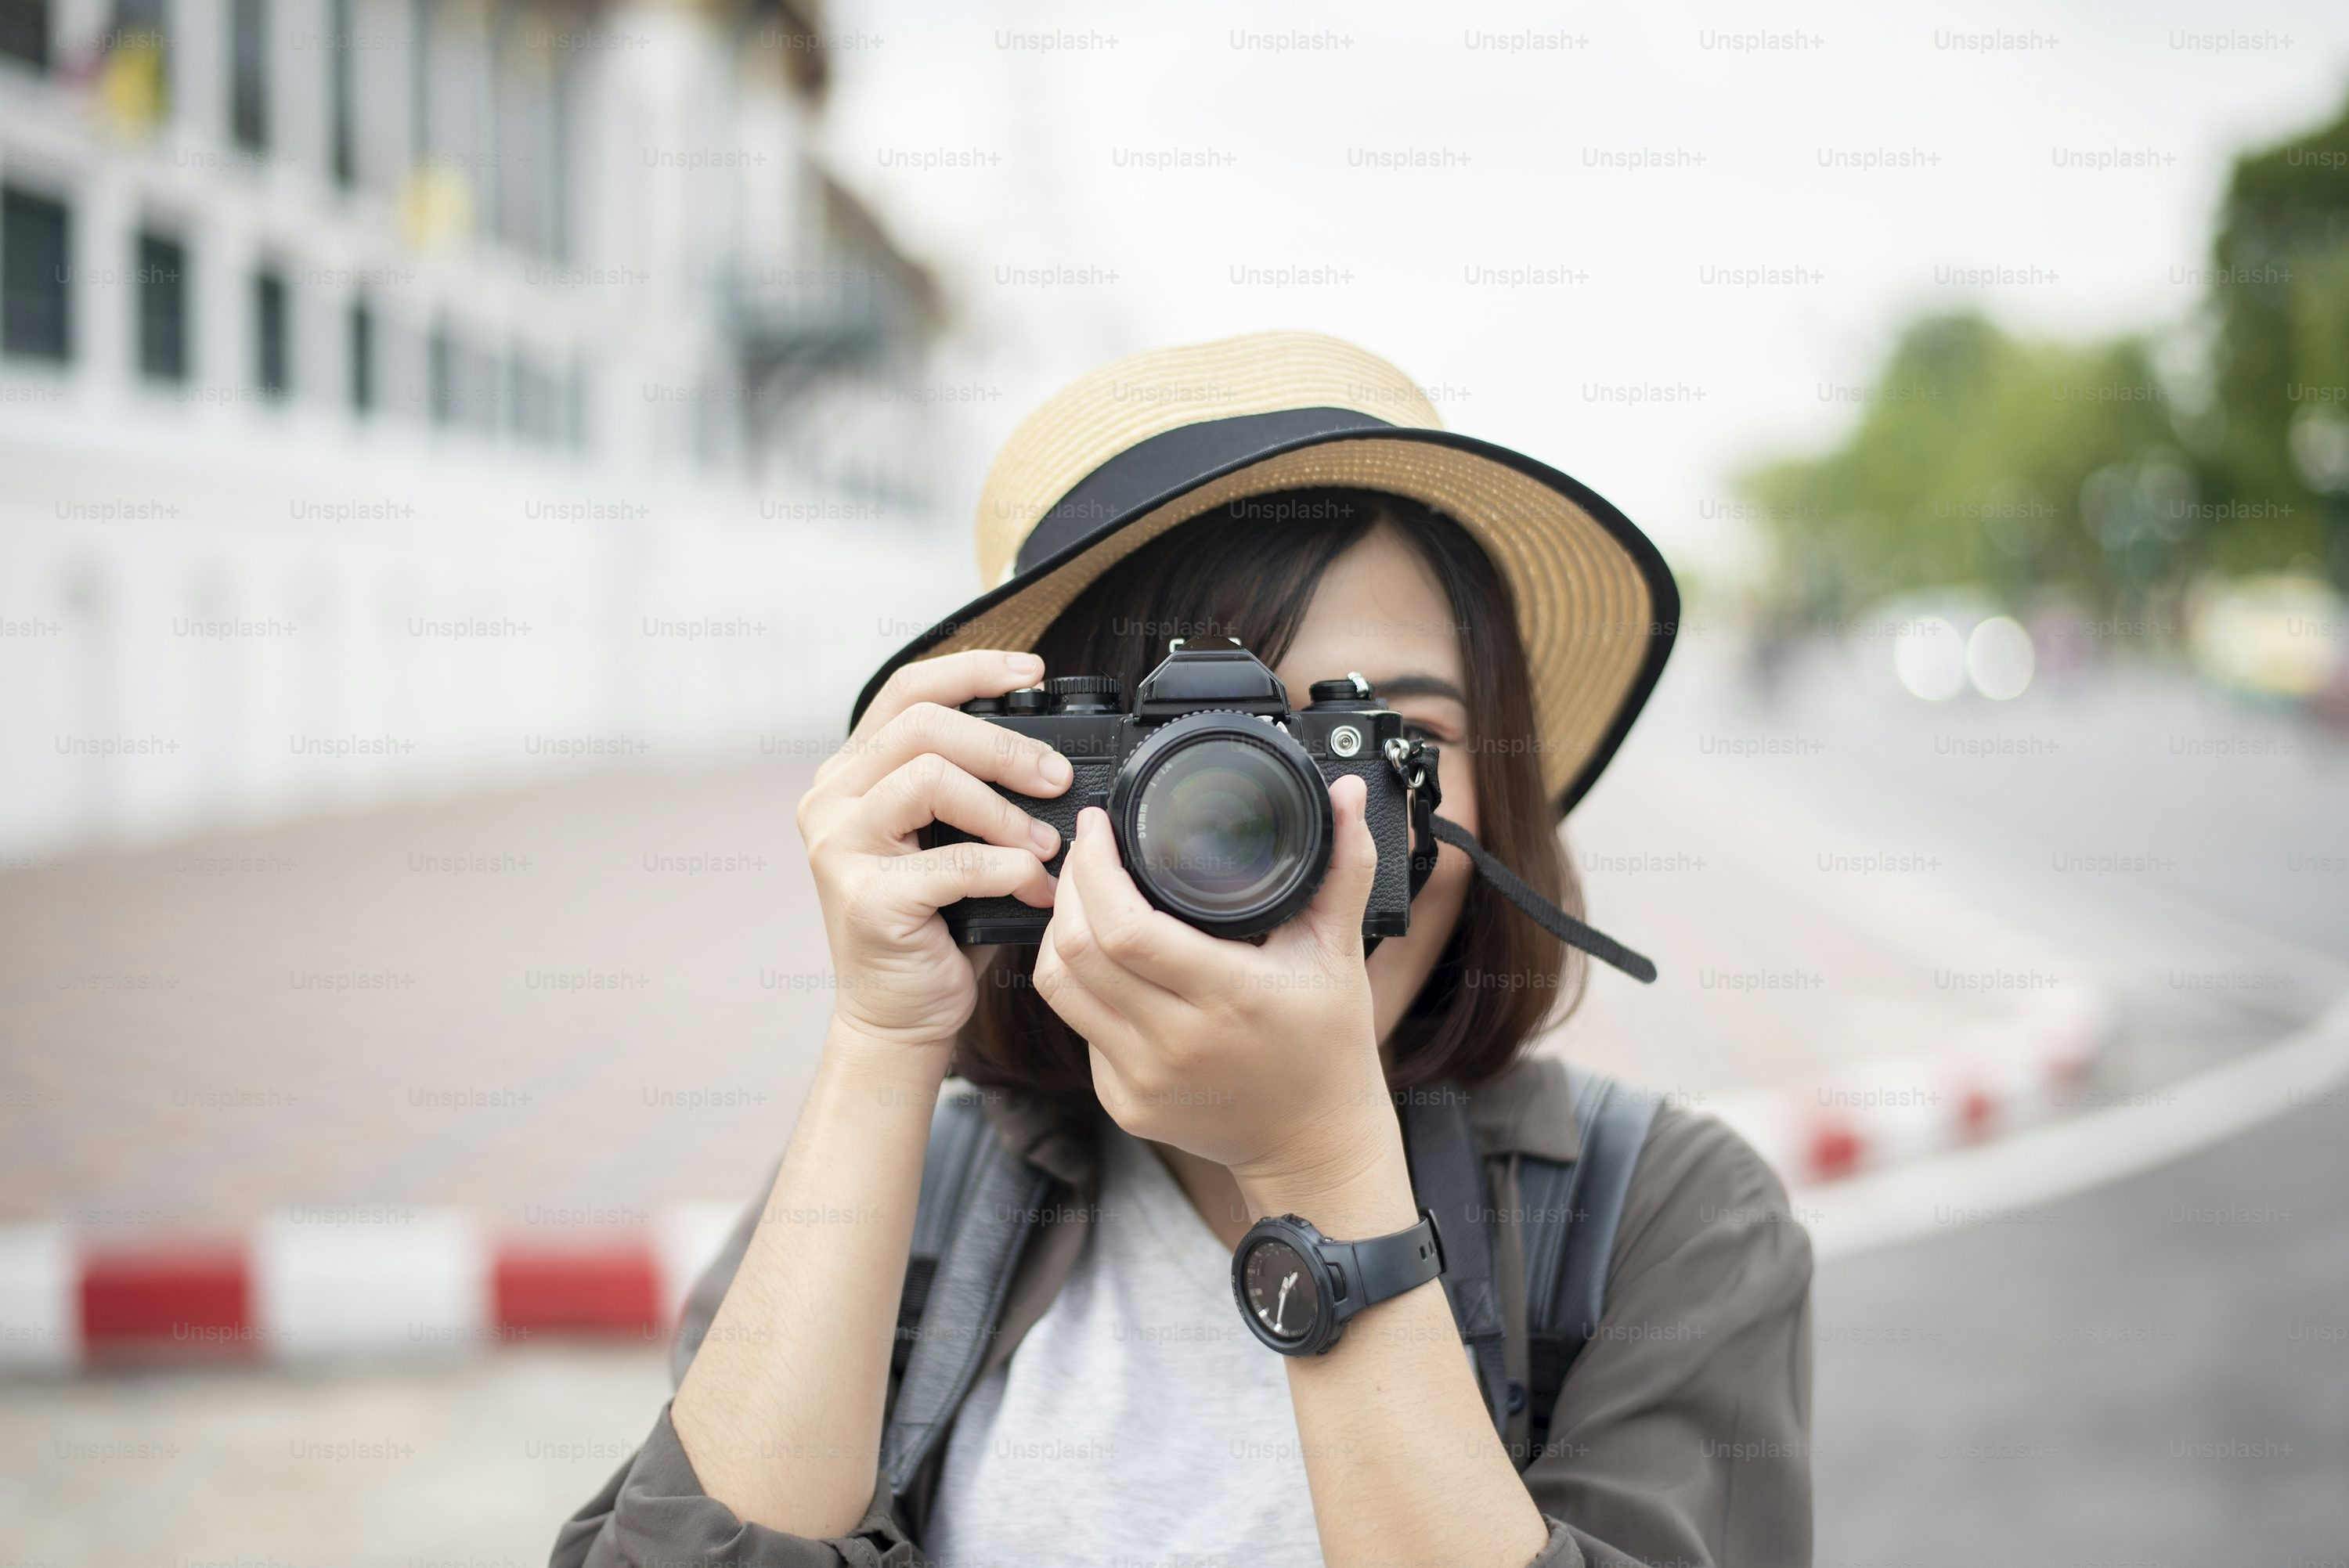

In [17]:
img_1_path = "/content/drive/MyDrive/DIP/Project(1)/camera.jpeg"
output=cartoon(cv2.imread(img_1_path))
Image("cartoon.jpg")

In [18]:
def update_c(C,hist):
    while True:
        groups=defaultdict(list)

        for i in range(len(hist)):
            if(hist[i] == 0):
                continue
            d=np.abs(C-i)
            index=np.argmin(d)
            groups[index].append(i)

        new_C=np.array(C)
        for i,indice in groups.items():
            if(np.sum(hist[indice])==0):
                continue
            new_C[i]=int(np.sum(indice*hist[indice])/np.sum(hist[indice]))

        if(np.sum(new_C-C)==0):
            break
        C=new_C

    return C,groups

In [19]:
def K_histogram(hist):

    alpha=0.001
    N=80
    C=np.array([128])

    while True:
        C,groups=update_c(C,hist)

        new_C=set()
        for i,indice in groups.items():
            if(len(indice)<N):
                new_C.add(C[i])
                continue

            z, pval=stats.normaltest(hist[indice])
            if(pval<alpha):
                left=0 if i==0 else C[i-1]
                right=len(hist)-1 if i ==len(C)-1 else C[i+1]
                delta=right-left
                if(delta >=3):
                    c1=(C[i]+left)/2
                    c2=(C[i]+right)/2
                    new_C.add(c1)
                    new_C.add(c2)
                else:
                    new_C.add(C[i])
            else:
                new_C.add(C[i])
        if(len(new_C)==len(C)):
            break
        else:
            C=np.array(sorted(new_C))
    return C

In [20]:
def cartoon(img):
    kernel = np.ones((2, 2), np.uint8)
    output = cv2.bilateralFilter(img, 5, 150, 150)  # Apply bilateral filter directly to img
    edge = cv2.Canny(output, 100, 200)
    output = cv2.cvtColor(output, cv2.COLOR_RGB2HSV)

    # Calculate histograms and centroids more concisely
    hists = [np.histogram(output[:, :, i], bins=np.arange(180 + 1 if i == 0 else 256 + 1))[0] for i in range(3)]
    C = [K_histogram(h) for h in hists]

    # Quantize colors
    output = output.reshape((-1, 3))
    for i in range(3):
        output[:, i] = C[i][np.argmin(np.abs(output[:, i, np.newaxis] - C[i]), axis=1)]
    output = output.reshape(img.shape)
    output = cv2.cvtColor(output, cv2.COLOR_HSV2RGB)

    # Draw contours and erode
    cv2.drawContours(output, cv2.findContours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0], -1, 0, thickness=1)
    output = cv2.erode(output, kernel, iterations=1)

    return output

In [21]:
output=cartoon(cv2.imread(img_1_path))
cv2.imwrite("cartoon.jpg", output)

True

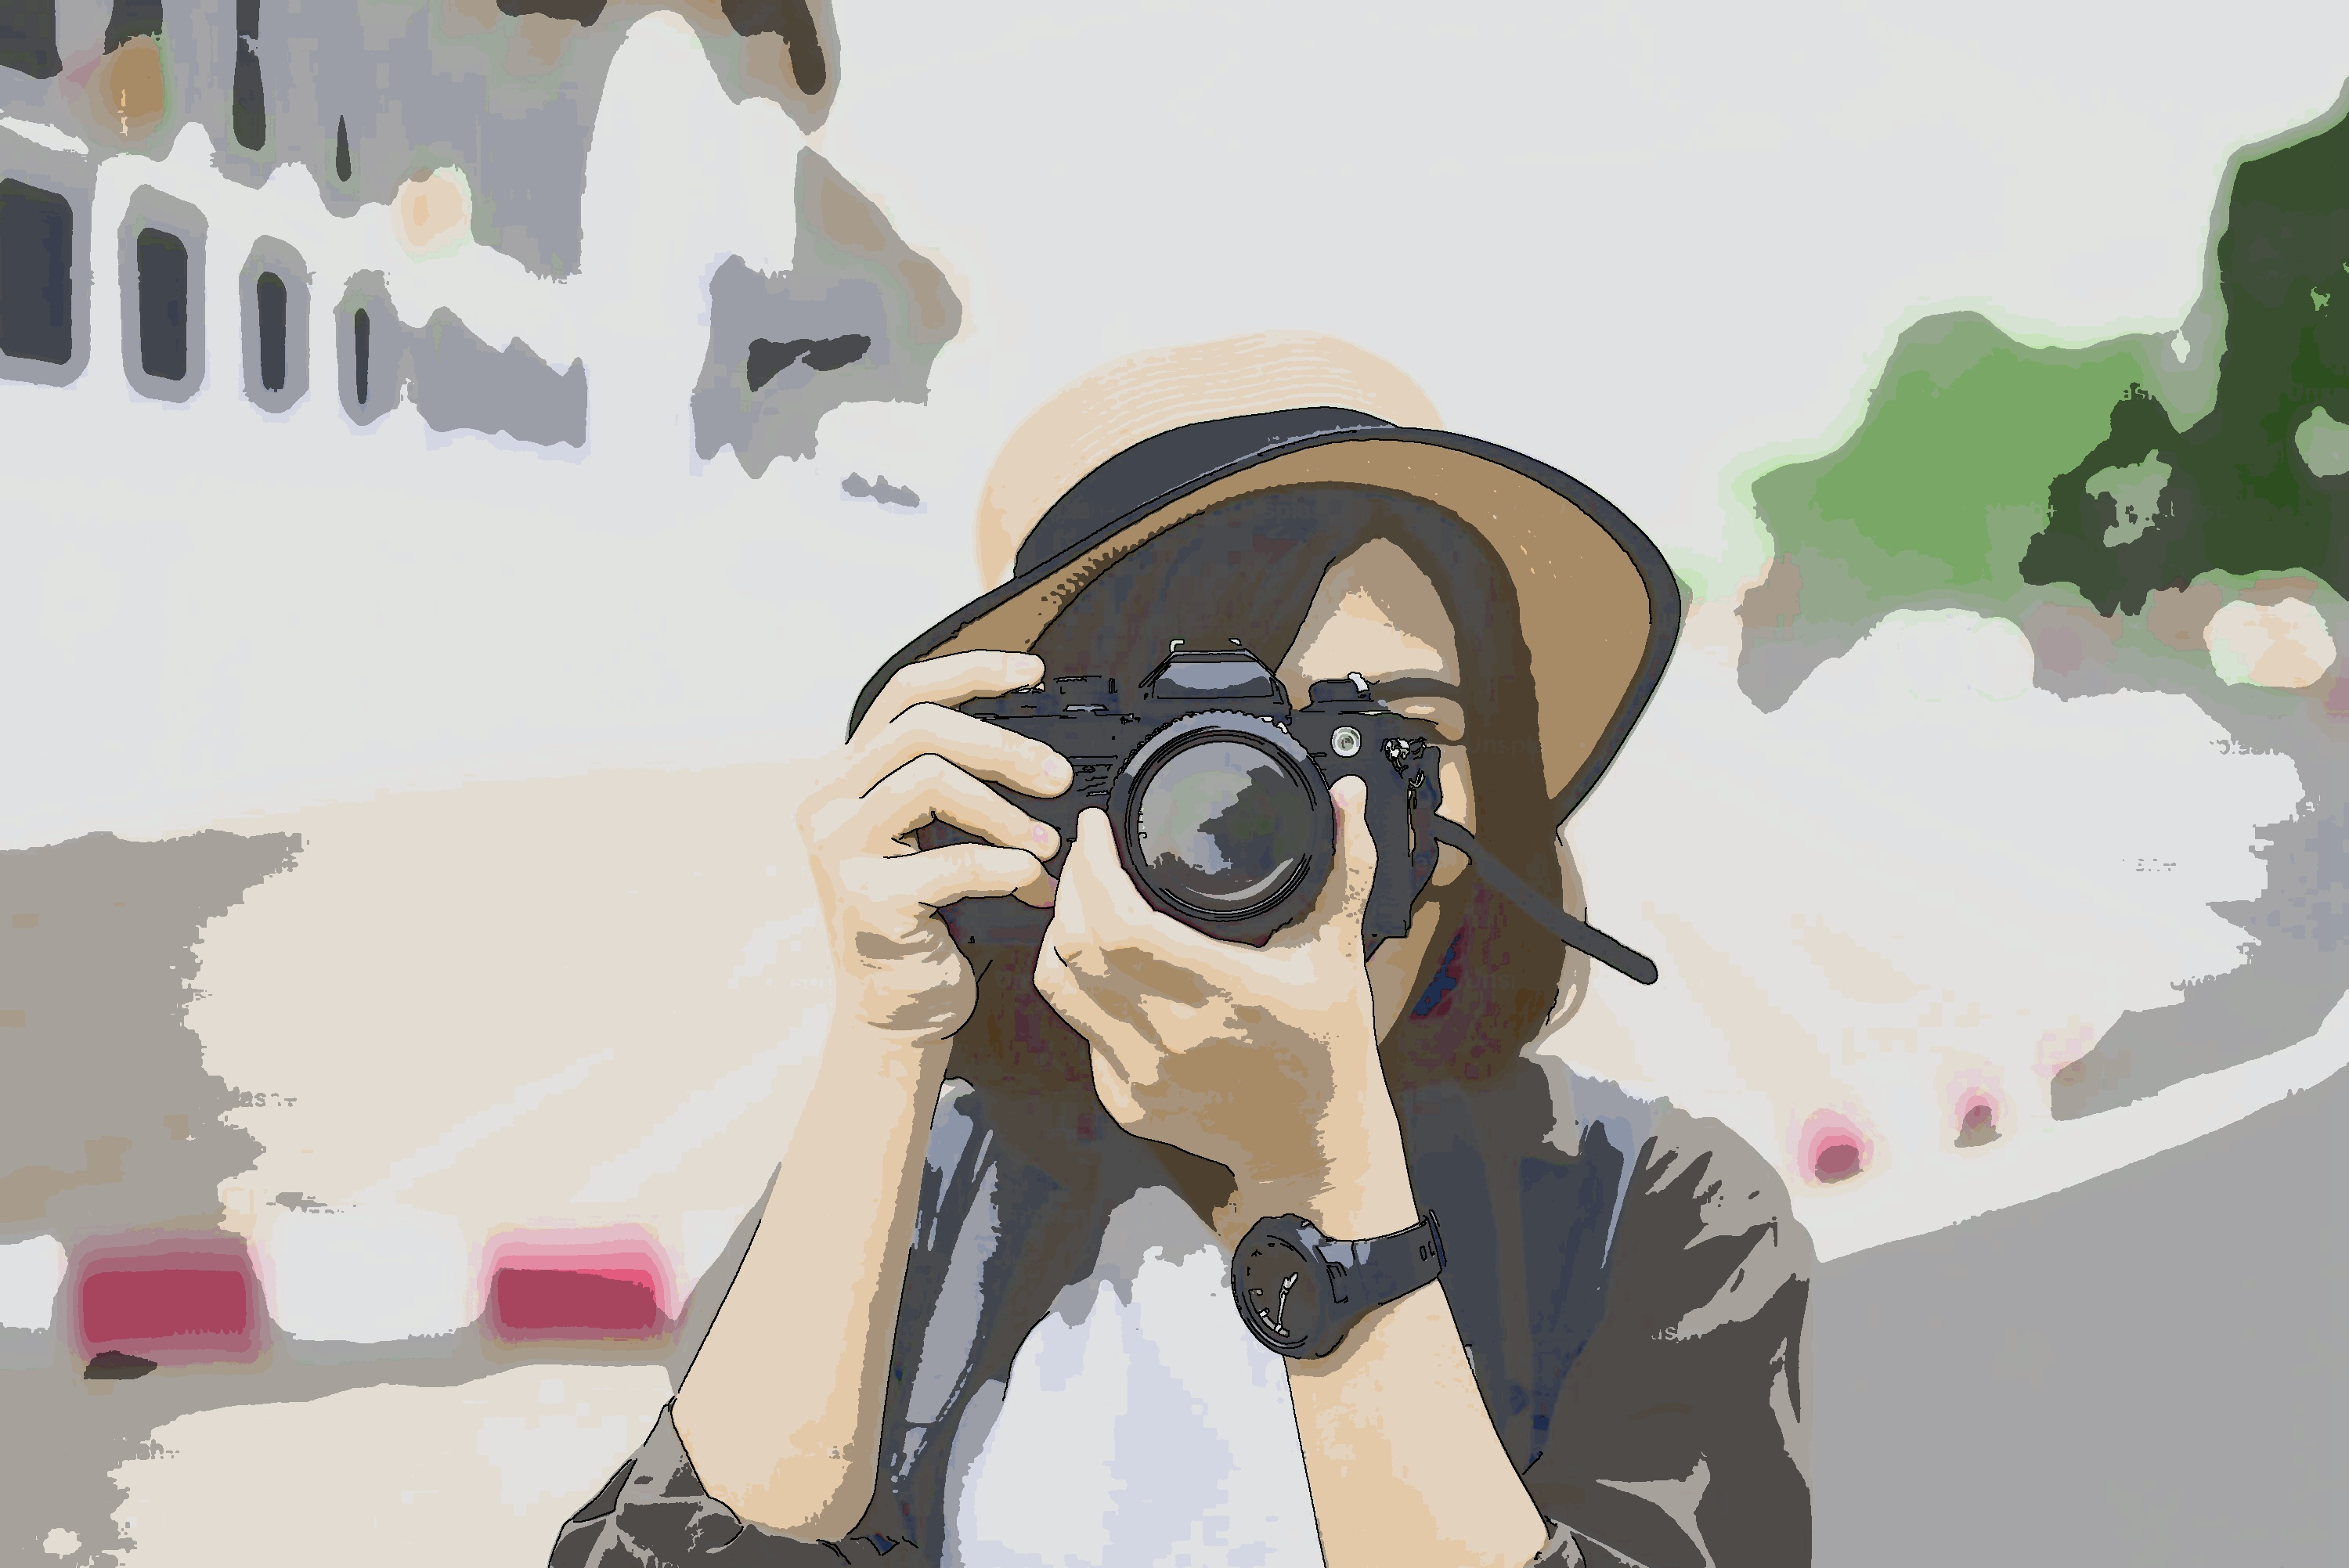

In [22]:
Image("cartoon.jpg")